# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import scorecardpy as sc
import random as rd
import re
from IPython.display import display
from matplotlib.backends.backend_pdf import PdfPages

# Data

In [3]:
# data prepare ------
# load germancredit data
smp_full = sc.germancredit()
smp_full['will_default'] = smp_full['creditability'].apply(lambda x: 1 if x == 'bad' else 0)
smp_full = smp_full.loc[:,smp_full.columns != 'creditability']
smp_full.loc[0:99, 'credit.amount'] = np.nan
smp_full.head()

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,personal.status.and.sex,other.debtors.or.guarantors,...,property,age.in.years,other.installment.plans,housing,number.of.existing.credits.at.this.bank,job,number.of.people.being.liable.to.provide.maintenance.for,telephone,foreign.worker,will_default
0,... < 0 DM,6,critical account/ other credits existing (not ...,radio/television,NaN,unknown/ no savings account,... >= 7 years,4,male : divorced/separated,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,0
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,NaN,... < 100 DM,1 <= ... < 4 years,2,male : divorced/separated,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,1
2,no checking account,12,critical account/ other credits existing (not ...,education,NaN,... < 100 DM,4 <= ... < 7 years,2,male : divorced/separated,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,0
3,... < 0 DM,42,existing credits paid back duly till now,furniture/equipment,NaN,... < 100 DM,4 <= ... < 7 years,2,male : divorced/separated,guarantor,...,building society savings agreement/ life insur...,45,none,for free,1,skilled employee / official,2,none,yes,0
4,... < 0 DM,24,delay in paying off in the past,car (new),NaN,... < 100 DM,1 <= ... < 4 years,3,male : divorced/separated,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,1


In [10]:
train, test = sc.split_df(smp_full, ratio=0.8).values()
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# 1. Preliminary analysis of variables (missings, outliers, concentration/distribution)

In [23]:
# columns that are not variables
var_skip = ['will_default']
# special values for numeric variables - TBD
spl_val = []
# list of variables by type (numeric variables with less than 10 unique values are considered as categorical)
var_cat, var_num = sc.var_types(train, var_skip)

In [20]:
if train['purpose'].dtype.name in ['category', 'object']: print(1)
else: print(0)

1


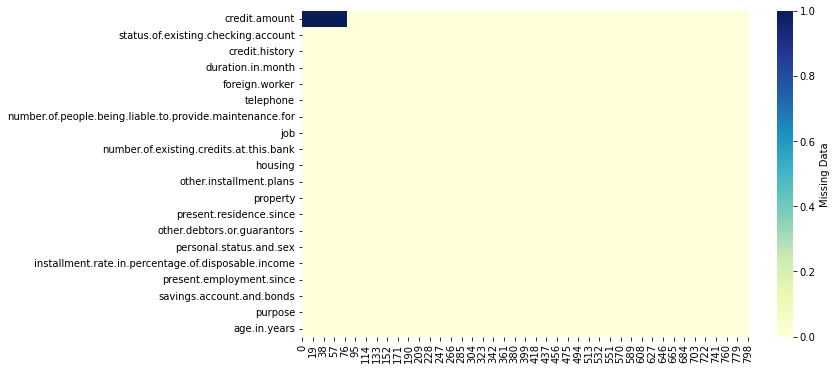

In [24]:
# heatmap for the missing values
percent_missing = train.loc[:, var_cat+var_num].isna().sum() * 100 / len(train)
percent_missing = pd.DataFrame({'column':percent_missing.index, 'percent_missing':percent_missing.values})
percent_missing.sort_values('percent_missing', ascending=False, inplace=True)
percent_missing.reset_index(drop=True)

plt.figure(figsize=(10,6))
sns.heatmap(train[percent_missing.column].isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("1_1_missings_heatmap.png", dpi=100, bbox_inches = "tight")

In [25]:
#round missings
#thresholds as params
# warning checks
var_cat_summary, var_num_summary = sc.var_pre_analysis(train, var_cat, var_num, spl_val, hhi_low=0.05, hhi_high=0.95, min_share=0.05)

writer = pd.ExcelWriter('1_2_preliminary_analysis.xlsx', engine='xlsxwriter')
var_cat_summary.to_excel(writer, sheet_name='var_cat_summary')
var_num_summary.to_excel(writer, sheet_name='var_num_summary')
writer.save()

display(var_cat_summary)
display(var_num_summary)

,Variable,HHI,Min share,Missings share,HHI warning,Min share warning,Missings warning
0,status.of.existing.checking.account,0.3034,0.0650,0.0,,,
1,credit.history,0.3829,0.0400,0.0,,Min share is 4.0%,
2,purpose,0.1881,0.0088,0.0,,Min share is 0.88%,
3,savings.account.and.bonds,0.4102,0.0500,0.0,,,
4,present.employment.since,0.2387,0.0650,0.0,,,
5,installment.rate.in.percentage.of.disposable.i...,0.3274,0.1363,0.0,,,
6,personal.status.and.sex,0.4103,0.0000,0.0,,Min share is 0.0%,
7,other.debtors.or.guarantors,0.8301,0.0387,0.0,,Min share is 3.87%,
8,present.residence.since,0.3085,0.1288,0.0,,,
9,property,0.2671,0.1550,0.0,,,


,Variable,Q1,Median,Q3,Lower whisker,Upper whisker,Share of outliers,Missings share,Outliers warning,Missings warning
0,duration.in.month,12.00,18.0,24.00,4.0,60.0,0.0012,0.0,0.12% outliers,
1,credit.amount,1371.75,2375.0,3962.25,250.0,11560.0,0.0200,0.1,2.0% outliers,10.0% missing values
2,age.in.years,27.00,33.0,42.00,19.0,75.0,0.0000,0.0,,


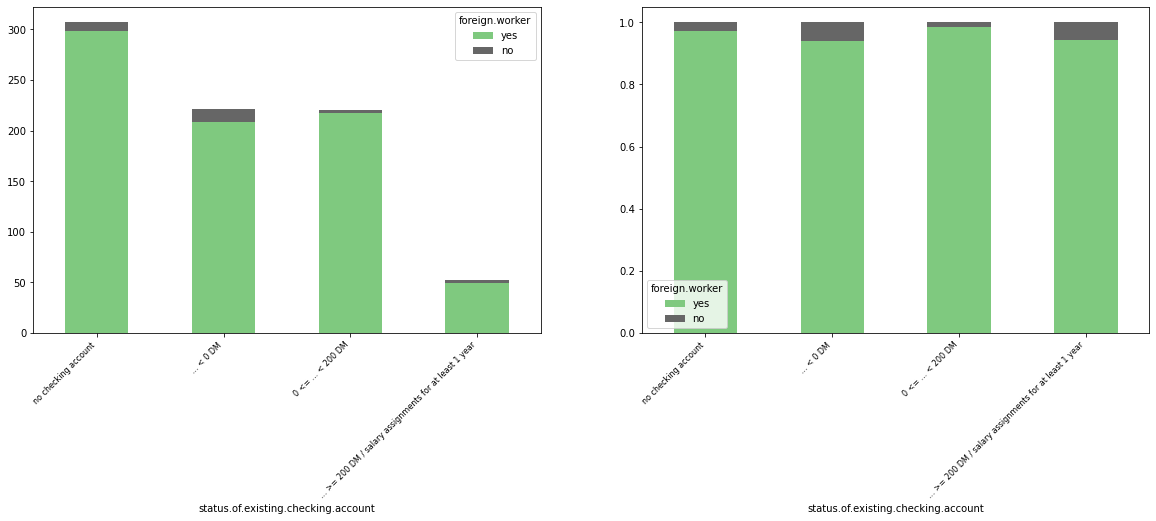

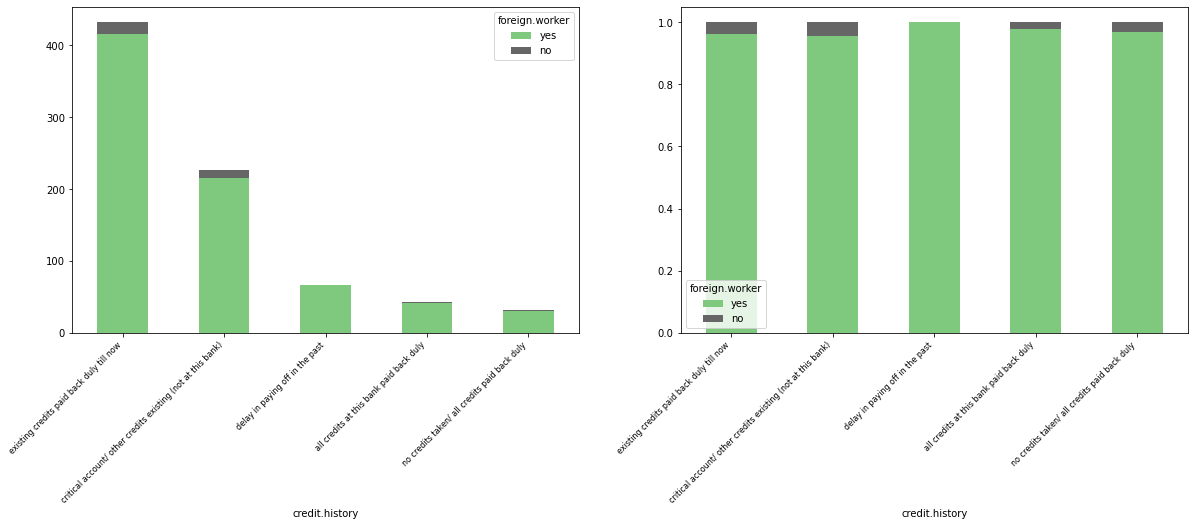

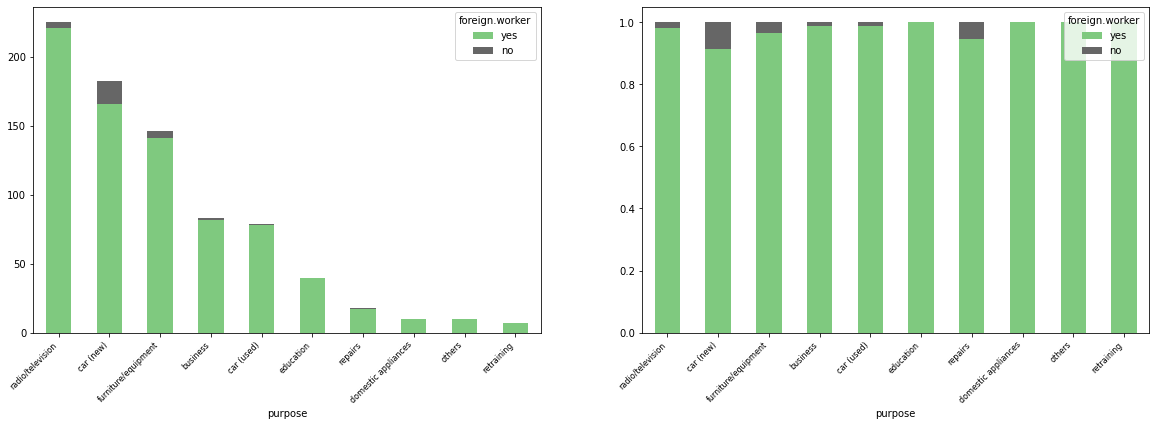

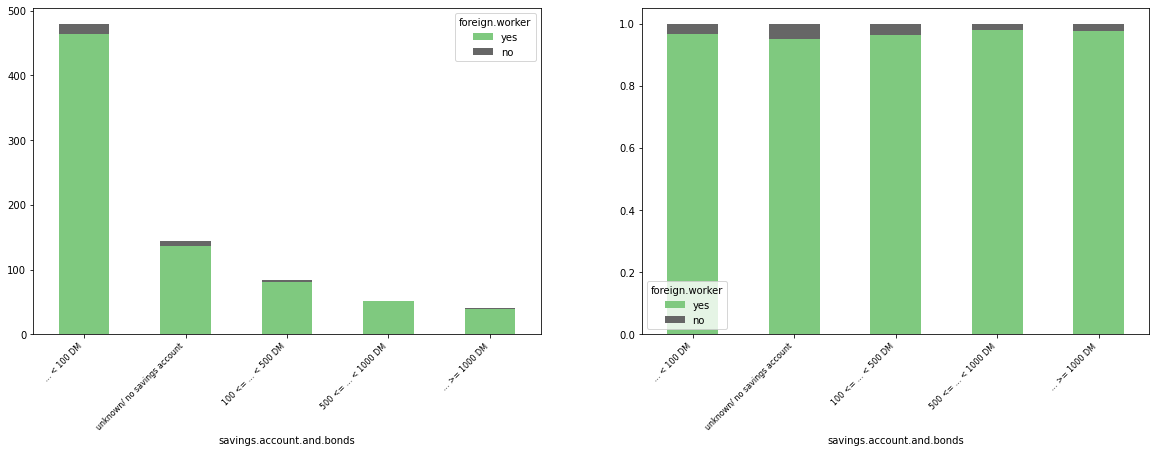

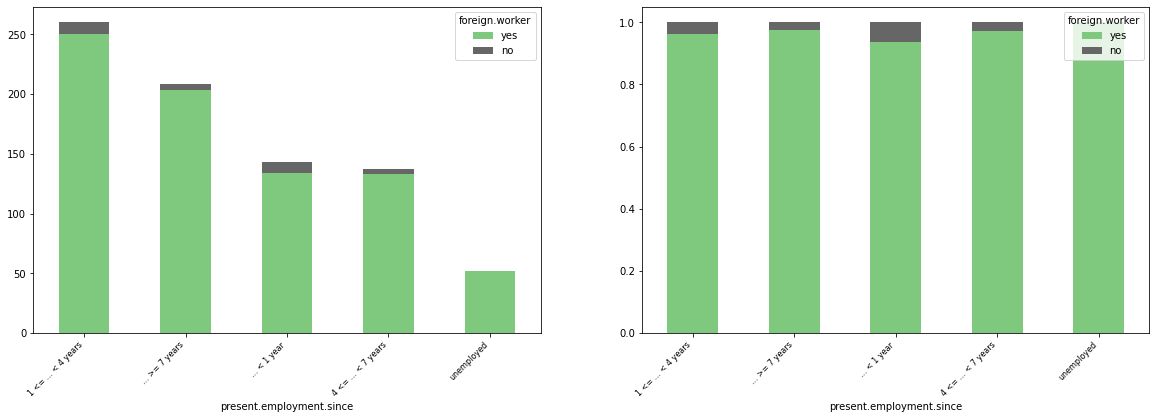

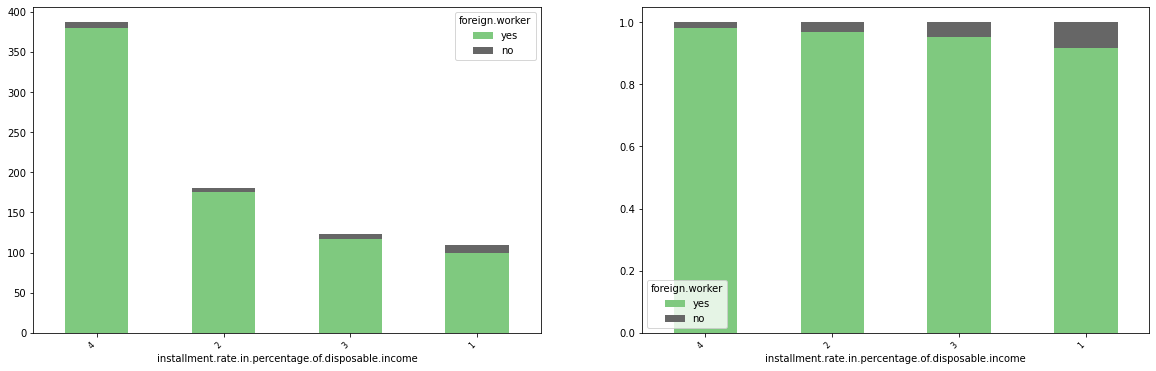

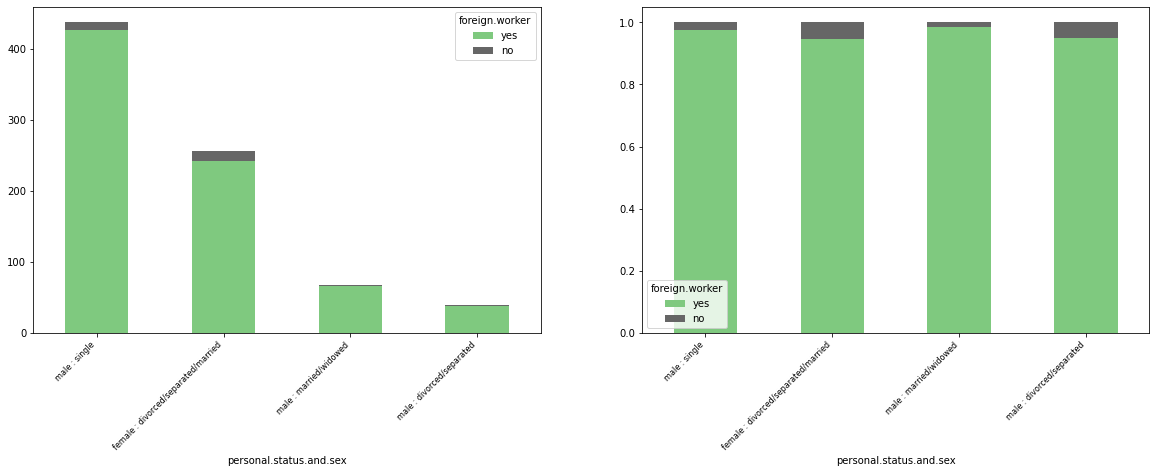

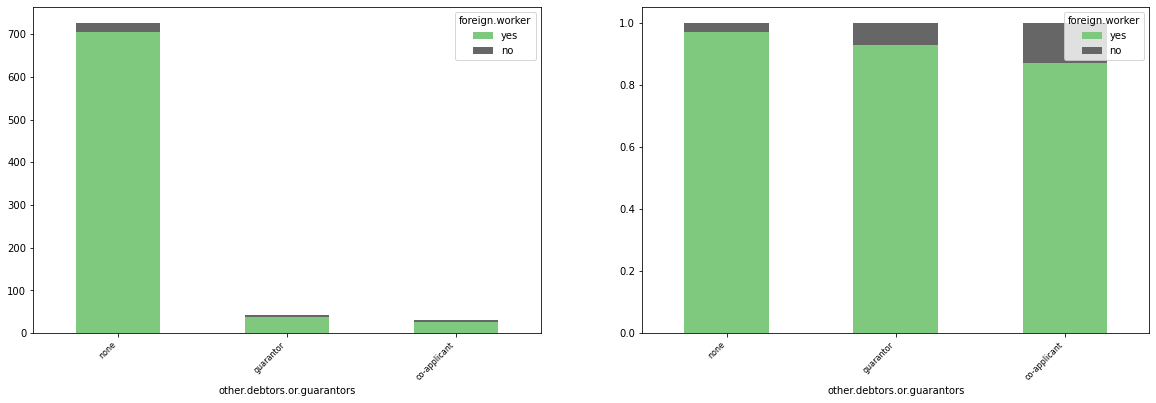

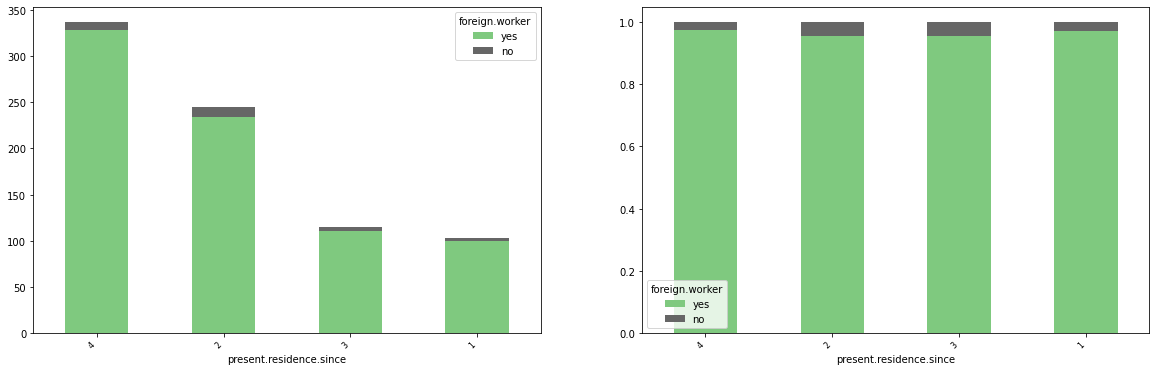

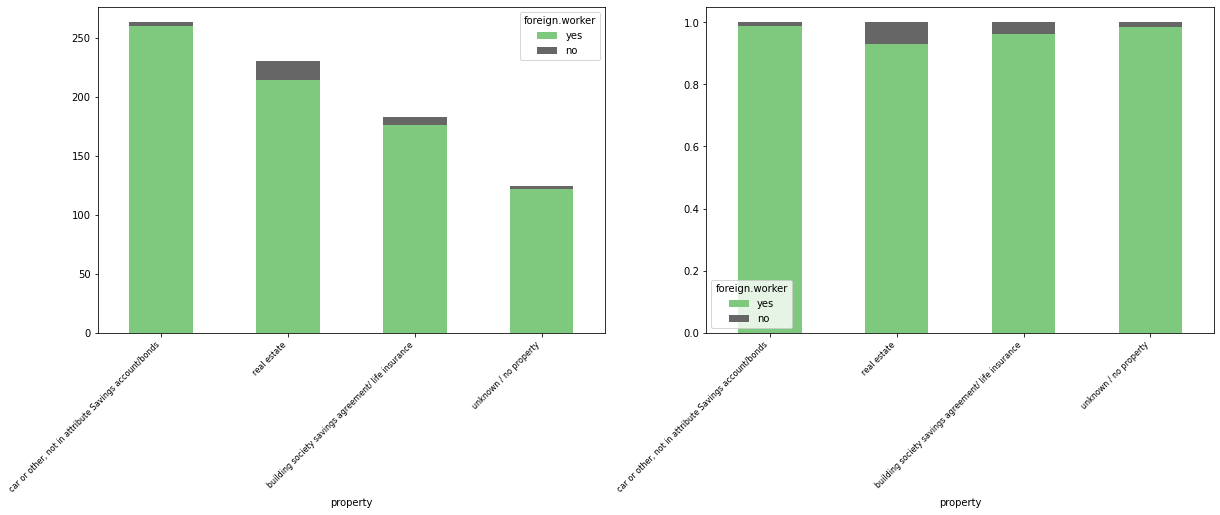

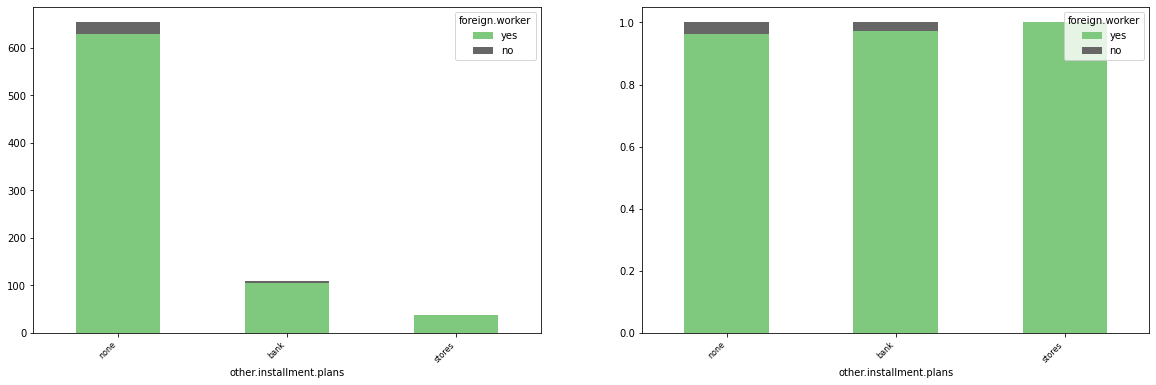

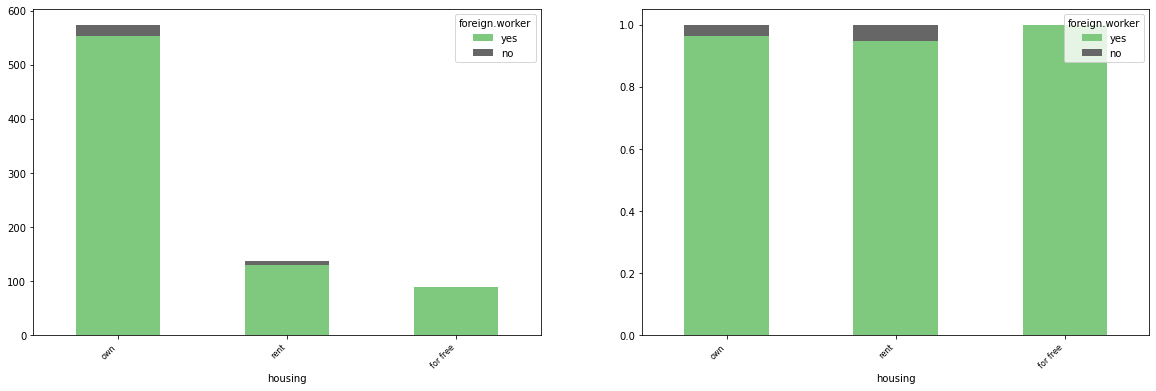

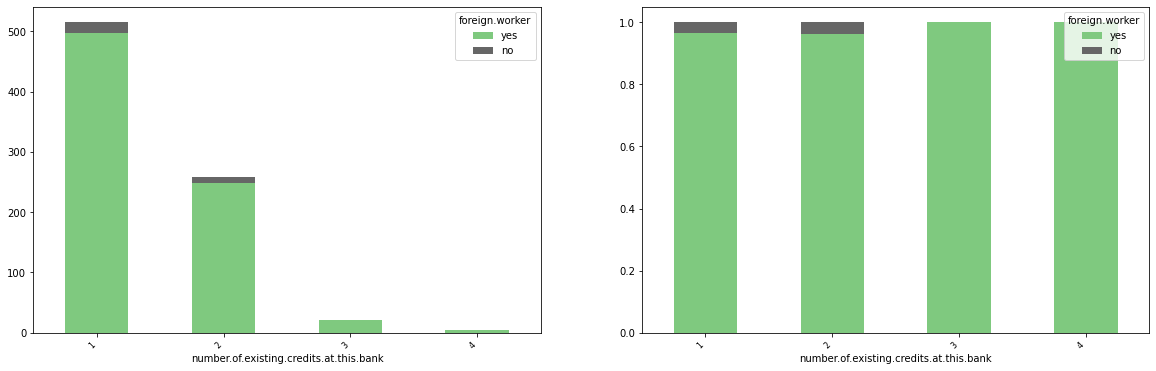

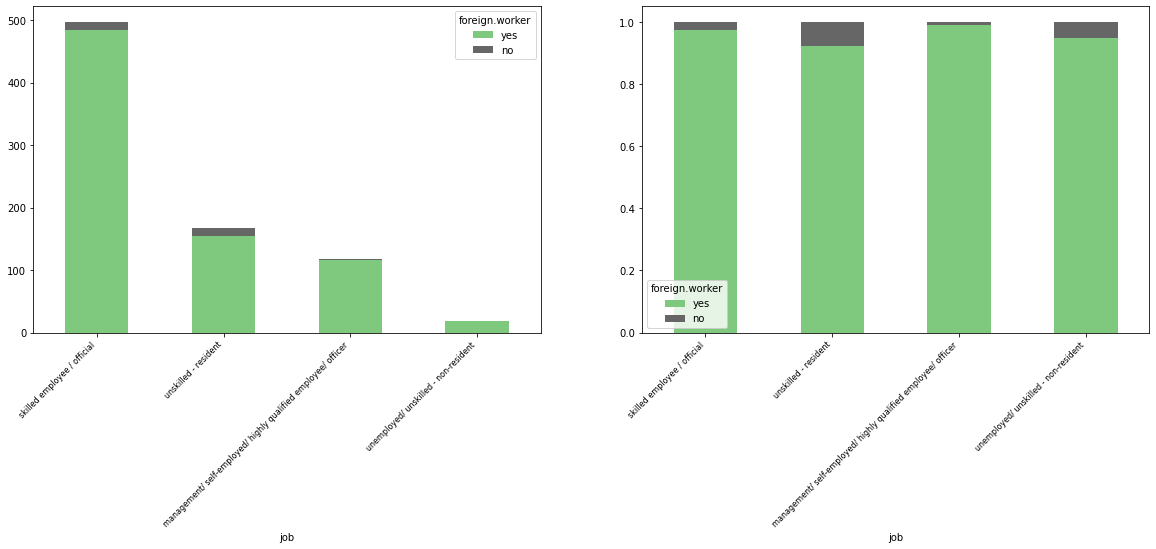

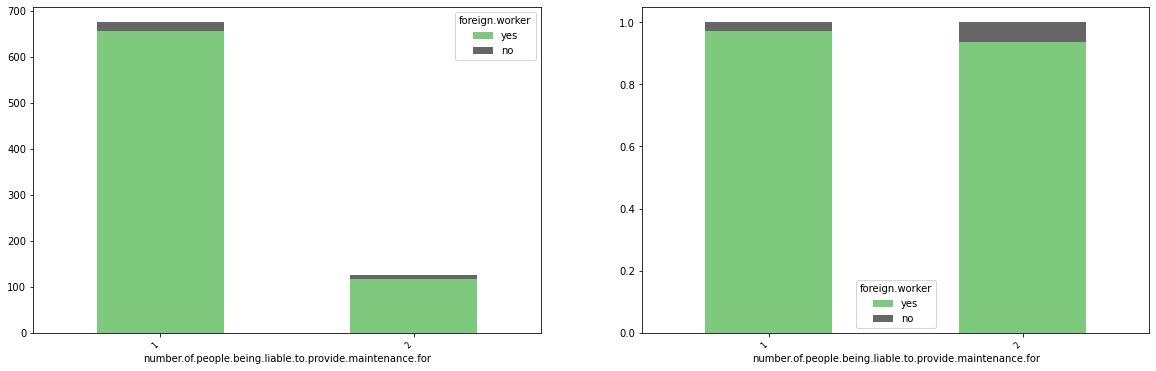

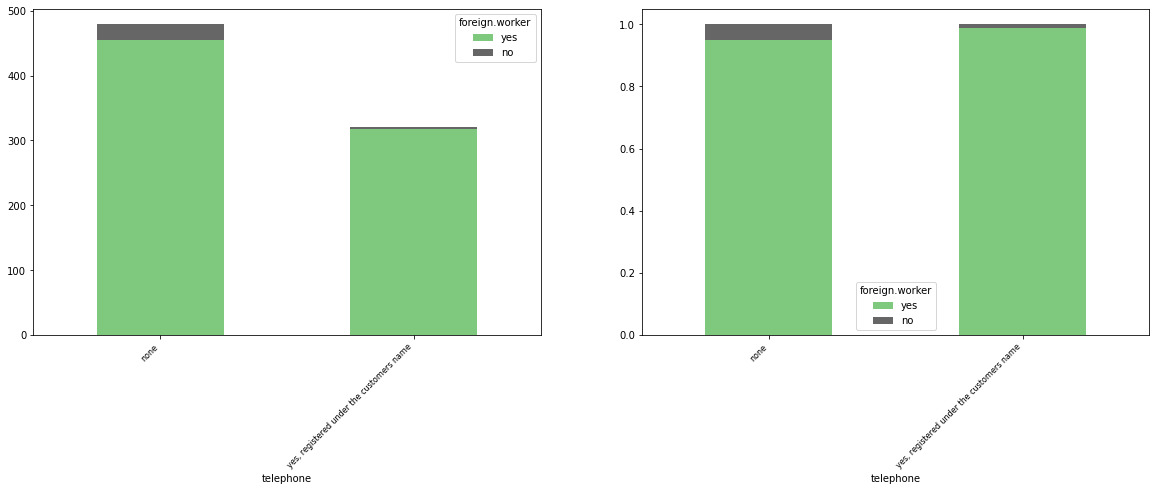

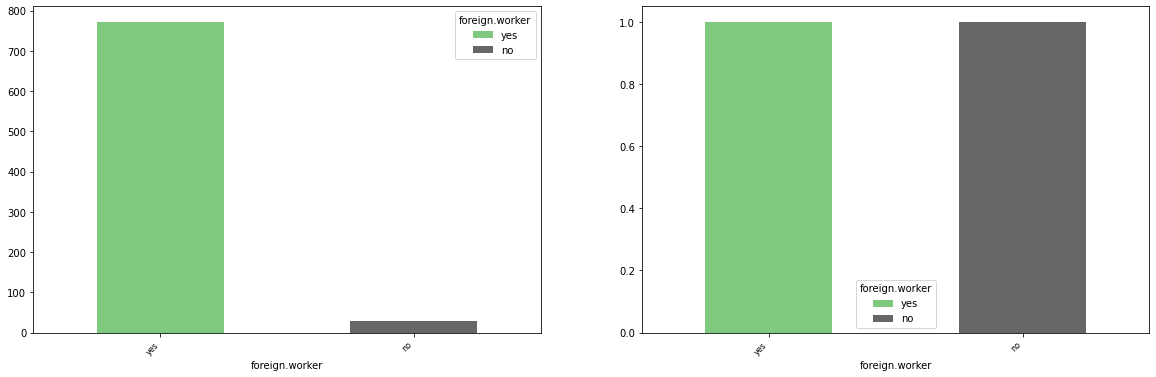

In [26]:
# distribution for categorical variables with extract to pdf
sc.var_cat_distr(train, var_cat, '1_3_categorical_vars_distribution.pdf', groupby='foreign.worker')

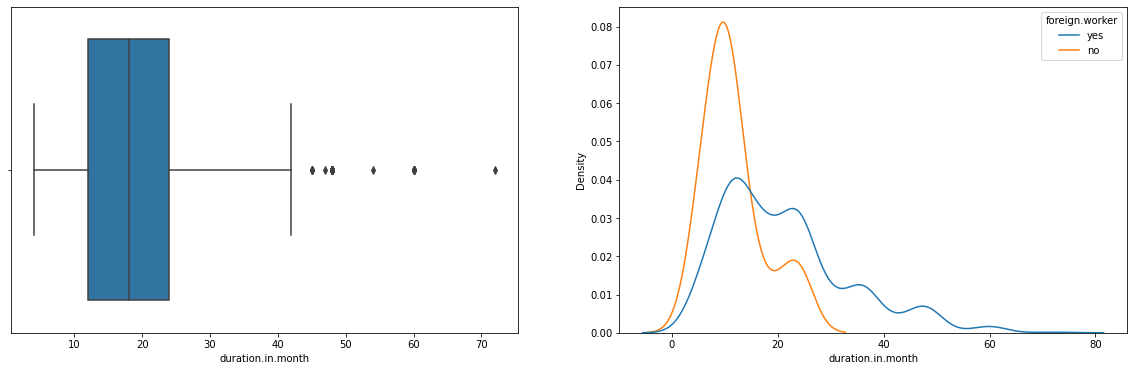

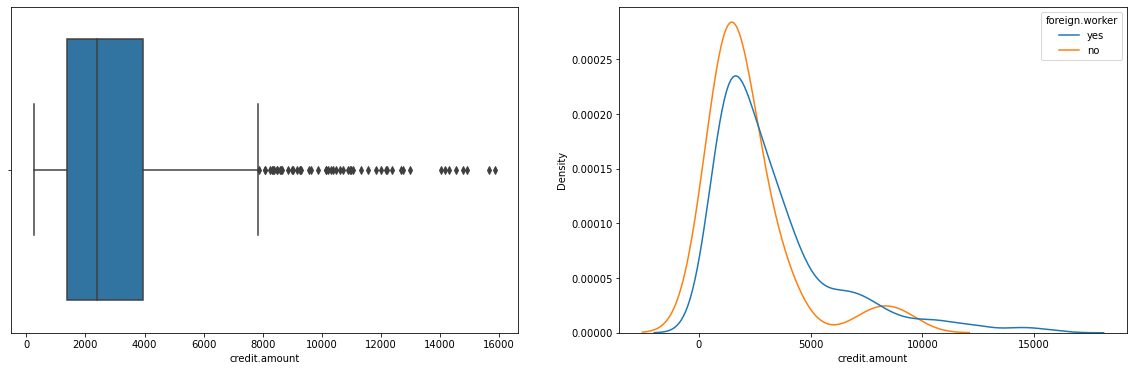

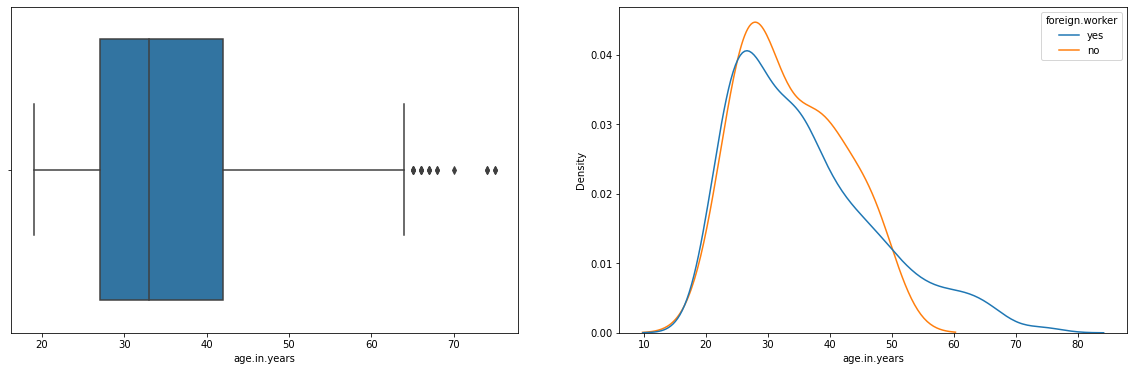

In [27]:
sc.var_num_distr(train, var_num, '1_4_numerical_vars_distribution', groupby='foreign.worker')

# 2. Automated binning

In [9]:
# binning
fine_class, coarse_class = sc.woebin(train, y = 'will_default', x = var_cat + var_num, init_count_distr = 0.05)


[INFO] creating woe binning ...


In [ ]:
'''
# replacing intervals by bin bumber in fine classing table (for better visibility)
bestbreaks_i = pd.to_numeric(coarse_class['credit.amount']['breaks0'])
bestbreaks_i = bestbreaks_i.append(pd.to_numeric(pd.Series('inf')), ignore_index=True)
fine_class['credit.amount']['bin'] = pd.cut(fine_class['credit.amount']['brkp'], bestbreaks_i, right=False, \
                                           labels = list(range(1, len(coarse_class['credit.amount']['bin'])+1)))
'''

In [10]:
# extracting binning results to excel
pd.concat(fine_class.values()).reset_index(drop=True).to_excel('2_1_fine_classing.xlsx')
pd.concat(coarse_class.values()).reset_index(drop=True).to_excel('2_2_coarse_classing_auto.xlsx')

'''
# each variable on a different sheet
def binning_export(binning_dict):
    writer = pd.ExcelWriter('2_1_fine_classing.xlsx', engine='xlsxwriter')
    for x_i in binning_dict:
        binning_dict[x_i].to_excel(writer, sheet_name=x_i[0:30])
    writer.save()
    return
binning_export(fine_class)
'''

"\n# each variable on a different sheet\ndef binning_export(binning_dict):\n    writer = pd.ExcelWriter('2_1_fine_classing.xlsx', engine='xlsxwriter')\n    for x_i in binning_dict:\n        binning_dict[x_i].to_excel(writer, sheet_name=x_i[0:30])\n    writer.save()\n    return\nbinning_export(fine_class)\n"

In [11]:
fine_class['credit.amount']

,brkp,variable,bin,good,bad,badprob
0,-inf,credit.amount,"[-inf,700.8)",25,11,0.305556
1,700.80,credit.amount,"[700.8,929.7)",25,11,0.305556
2,929.70,credit.amount,"[929.7,1166.05)",24,12,0.333333
3,1166.05,credit.amount,"[1166.05,1262.0)",22,13,0.371429
4,1262.00,credit.amount,"[1262.0,1371.75)",25,12,0.324324
5,1371.75,credit.amount,"[1371.75,1493.7)",30,6,0.166667
6,1493.70,credit.amount,"[1493.7,1676.5)",29,7,0.194444
7,1676.50,credit.amount,"[1676.5,1914.6)",27,9,0.250000
8,1914.60,credit.amount,"[1914.6,2128.4)",24,12,0.333333
9,2128.40,credit.amount,"[2128.4,2375.0)",26,10,0.277778


In [ ]:
fine_class['status.of.existing.checking.account']

In [ ]:
display(coarse_class['credit.amount'])


In [ ]:
# iv for variables after automated binning
coarse_class_iv = sc.vars_iv(var_cat + var_num, coarse_class)

In [ ]:
coarse_class_iv

In [ ]:
# binning visualization
sc.woebin_plot(coarse_class)

# 3. Binning adjustments 

-------- 1/12 age.in.years --------


,brkp,variable,bin,good,bad,badprob
0,-inf,age.in.years,"[-inf,22.0)",17,10,0.370370
1,22.0,age.in.years,"[22.0,23.0)",14,7,0.333333
2,23.0,age.in.years,"[23.0,24.0)",21,18,0.461538
3,24.0,age.in.years,"[24.0,26.0)",42,30,0.416667
4,26.0,age.in.years,"[26.0,27.0)",29,11,0.275000
5,27.0,age.in.years,"[27.0,28.0)",31,9,0.225000
6,28.0,age.in.years,"[28.0,29.0)",22,11,0.333333
7,29.0,age.in.years,"[29.0,30.0)",20,11,0.354839
8,30.0,age.in.years,"[30.0,32.0)",34,16,0.320000
9,32.0,age.in.years,"[32.0,33.0)",19,6,0.240000


>>> Current breaks:
26.0,28.0,35.0,52.0 



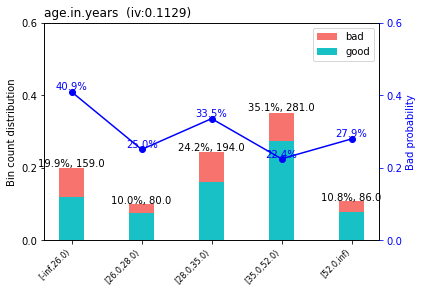

>>> Adjust breaks for (1/12) age.in.years?
1: next 
2: yes 
3: back


KeyboardInterrupt: Interrupted by user

In [18]:
# manual review and adjustment of binning
breaks_list = sc.woebin_adj(train, y="will_default", bins=coarse_class, fine_bins=fine_class, adj_all_var=False)

In [ ]:
# update of coarse classing table (fine classing is relevant only for automated binning)
fine_class_adj, coarse_class_adj = sc.woebin(train, y = 'will_default', x = var_cat + var_num, breaks_list = breaks_list, init_count_distr = 0.02)

In [ ]:
# review of binning after adjustments
breaks_list = sc.woebin_adj(train, y="will_default", bins=coarse_class_adj)

In [ ]:
# applying woe transformations on train and test samples 
train_woe = sc.woebin_ply(train, bins=coarse_class_adj)
test_woe = sc.woebin_ply(test, bins=coarse_class_adj)

# 4. TBD Correlation analysis

# 5. Logistic regression

In [ ]:
# target and variables
y_train = train_woe.loc[:,'will_default']
X_train = train_woe.loc[:,train_woe.columns != 'will_default']
y_test = test_woe.loc[:,'will_default']
X_test = test_woe.loc[:,train_woe.columns != 'will_default']

In [ ]:
# logistic regression ------
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
# lr.coef_
# lr.intercept_

In [ ]:
# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]
# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# 6. Initial calibration and scorecard points

In [ ]:
# score ------
card = sc.scorecard(coarse_class_adj, lr, X_train.columns, start_zero=True)
# credit score
train_score  = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

In [ ]:
scorecard_points = pd.concat(card, ignore_index=True)
scorecard_points.to_excel("scorecard_points.xlsx", sheet_name='scorecard_points')